In [2]:
# Standard library imports
from urllib.request import urlretrieve
import tarfile
import pandas as pd
import hashlib
import re
from datetime import datetime

# Visualization imports
import matplotlib.pyplot as plt
import seaborn as sns

# Scikit-learn imports
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, precision_score, recall_score, precision_recall_curve, roc_curve, auc
from collections import Counter
import re
from wordcloud import WordCloud
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, precision_recall_curve, roc_curve, auc
import re

## Downloading the dataset

In [4]:
import os
from urllib.request import urlretrieve
import tarfile

# Define links and file paths
ham_link = 'https://spamassassin.apache.org/old/publiccorpus/20021010_easy_ham.tar.bz2'
spam_link = 'https://spamassassin.apache.org/old/publiccorpus/20021010_spam.tar.bz2'
ham_file_path = 'easy_ham.tar.bz2'
spam_file_path = 'spam.tar.bz2'
data_dir = 'data'

# Download and extract only if 'data' folder doesn’t exist
if not os.path.exists(data_dir):
    print("Downloading and extracting datasets...")
    urlretrieve(ham_link, ham_file_path)
    urlretrieve(spam_link, spam_file_path)
    
    ham_file = tarfile.open(ham_file_path, 'r:bz2')
    spam_file = tarfile.open(spam_file_path, 'r:bz2')
    
    ham_file.extractall(data_dir)
    spam_file.extractall(data_dir)
    
    ham_file.close()
    spam_file.close()
    print("Download and extraction complete.")
else:
    print("Data folder already exists, skipping download and extraction.")

Data folder already exists, skipping download and extraction.


## Loading the data

In [6]:
# Loading the files in the data folder
import os

ham_filenames = [name for name in sorted(os.listdir('data/easy_ham')) if len(name) > 20]
spam_filenames = [name for name in sorted(os.listdir('data/spam')) if len(name) > 20]

print('Number of ham files:', len(ham_filenames))
print('Number of spam files:', len(spam_filenames))

df = pd.DataFrame(ham_filenames + spam_filenames, columns=['email_id'])

def to_uuid(id_str):
    # Create a SHA-256 hash and return the first 16 hex characters
    return hashlib.sha256(id_str.encode()).hexdigest()[:16]

# Convert all file names to UUIDs
df['email_id'] = df['email_id'].apply(to_uuid)
df.head()

# Pre-calculate the ham UUIDs for correct spam flag assignment
ham_uuids = [to_uuid(name) for name in ham_filenames]
df['is_spam'] = df['email_id'].apply(lambda x: 0 if x in ham_uuids else 1)
df.head()

contents = []

def read_file_and_append(filepath):
    with open(filepath, 'rb') as f:
        contents.append(f.read().decode('latin1'))

# Reading ham files
for filename in ham_filenames:
    read_file_and_append(os.path.join('data', 'easy_ham', filename))

# Reading spam files
for filename in spam_filenames:
    read_file_and_append(os.path.join('data', 'spam', filename))

df['content'] = contents
df.head()

Number of ham files: 2551
Number of spam files: 501


,email_id,is_spam,content
0,98e7e744d4b0ea78,0,From exmh-workers-admin@redhat.com Thu Aug 22...
1,e953def9713ad64f,0,From Steve_Burt@cursor-system.com Thu Aug 22 ...
2,a9c3be24be981dbe,0,From timc@2ubh.com Thu Aug 22 13:52:59 2002\n...
3,1874bd560ea2aaa8,0,From irregulars-admin@tb.tf Thu Aug 22 14:23:...
4,976351ae57c8b54c,0,From exmh-users-admin@redhat.com Thu Aug 22 1...


## Defining Feautures

In [8]:
df['sender'] = df['content'].apply(lambda x: x.split("From " or "from")[1].split()[0] if "From " in x else None)
df['subject'] = df['content'].apply(lambda x: x.split("Subject: ")[1].split("\n")[0] if "Subject: " in x else None)
df['date'] = df['content'].apply(lambda x: x.split("Date: ")[1].split("\n")[0] if "Date: " in x else None)
df['content-type'] = df['content'].apply(lambda x: x.split("Content-Type: ")[1].split("\n")[0] if "Content-Type: " in x else None)
df['content'] = df['content'].apply(lambda x: x.split("\n\n")[1] if "\n\n" in x else None)
df.head()

,email_id,is_spam,content,sender,subject,date,content-type
0,98e7e744d4b0ea78,0,"Date: Wed, 21 Aug 2002 10:54:46 -05...",exmh-workers-admin@redhat.com,Re: New Sequences Window,"Thu, 22 Aug 2002 18:26:25 +0700",text/plain; charset=us-ascii
1,e953def9713ad64f,0,"Martin A posted:\nTassos Papadopoulos, the Gre...",Steve_Burt@cursor-system.com,[zzzzteana] RE: Alexander,"Thu, 22 Aug 2002 12:46:18 +0100",text/plain; charset=US-ASCII
2,a9c3be24be981dbe,0,Man Threatens Explosion In Moscow,timc@2ubh.com,[zzzzteana] Moscow bomber,"Thu, 22 Aug 2002 13:52:38 +0100",text/plain; charset=US-ASCII
3,1874bd560ea2aaa8,0,Klez: The Virus That Won't Die\n \nAlready the...,irregulars-admin@tb.tf,[IRR] Klez: The Virus That Won't Die,"Thu, 22 Aug 2002 09:15:25 -0400","text/plain; charset=""us-ascii"""
4,976351ae57c8b54c,0,"On Wed Aug 21 2002 at 15:46, Ulises Ponce wrote:",exmh-users-admin@redhat.com,Re: Insert signature,"Thu, 22 Aug 2002 23:36:32 +1000",None


## Adding time

In [10]:
# Extract time of day from date strings
import email.utils

def extract_time_of_day(date_str):
    """Extract the hour (0-23) from a date string."""
    if pd.isna(date_str):
        return None
    
    try:
        # First try parsing with email.utils for standard email date formats
        try:
            parsed_date = email.utils.parsedate_tz(date_str)
            if parsed_date:
                # parsedate_tz returns a tuple, with hours at index 3
                return parsed_date[3]
        except:
            pass
        
        # Try to find hour:minute pattern in the string
        match = re.search(r'(\d{1,2}):\d{1,2}:\d{1,2}', date_str)
        if match:
            return int(match.group(1))
        
        match = re.search(r'(\d{1,2}):\d{1,2}', date_str)
        if match:
            return int(match.group(1))
        
        # If all else fails, try datetime parsing with common formats
        for fmt in ('%a, %d %b %Y %H:%M:%S %z', '%d %b %Y %H:%M:%S %z'):
            try:
                dt = datetime.strptime(date_str, fmt)
                return dt.hour
            except ValueError:
                continue
        
        return None  # If no pattern matched
    except:
        return None  # Return None for any errors

# Apply the function to create time_of_day column
df['time_of_day'] = df['date'].apply(extract_time_of_day)

## Cleaning the data


Checking for missing values

In [13]:
for col in df.columns:
    print(f'{col}: {df[col].isnull().sum()} missing values')

email_id: 0 missing values
is_spam: 0 missing values
content: 1 missing values
sender: 175 missing values
subject: 1 missing values
date: 1 missing values
content-type: 435 missing values
time_of_day: 1 missing values


In [14]:
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
import pandas as pd

# Define feature groups
text_features = ['sender', 'subject', 'content-type', 'content']
numeric_features = ['time_of_day']
passthrough_features = ['is_spam']  # Explicitly keep 'is_spam'

# Create imputers
text_imputer = SimpleImputer(strategy='constant', fill_value='unknown')
numeric_imputer = SimpleImputer(strategy='constant', fill_value=12)

# ColumnTransformer for imputation
imputer = ColumnTransformer(
    transformers=[
        ('text', text_imputer, text_features),
        ('num', numeric_imputer, numeric_features),
        ('pass', 'passthrough', passthrough_features)  # Explicitly passthrough 'is_spam'
    ],
    remainder='drop'  # Drop any unspecified columns (if any)
)

# Apply imputation
# Ensure df has all required columns before transforming
required_columns = text_features + numeric_features + passthrough_features
df_subset = df[required_columns]  # Select only the columns we need
df_imputed = pd.DataFrame(
    imputer.fit_transform(df_subset),
    columns=text_features + numeric_features + passthrough_features
)

# Add derived features
df_imputed['content_length'] = df_imputed['content'].str.len()
df_imputed['subject_length'] = df_imputed['subject'].str.len()
df_imputed['content_length'] = df_imputed['content_length'].clip(upper=df_imputed['content_length'].quantile(0.99))
df_imputed['subject_length'] = df_imputed['subject_length'].clip(upper=df_imputed['subject_length'].quantile(0.99))

# Update df
df = df_imputed
print(df.head())  # Use print for Jupyter visibility

                          sender                                subject  \
0  exmh-workers-admin@redhat.com               Re: New Sequences Window   
1   Steve_Burt@cursor-system.com              [zzzzteana] RE: Alexander   
2                  timc@2ubh.com              [zzzzteana] Moscow bomber   
3         irregulars-admin@tb.tf  [IRR] Klez: The Virus That  Won't Die   
4    exmh-users-admin@redhat.com                   Re: Insert signature   

                     content-type  \
0    text/plain; charset=us-ascii   
1    text/plain; charset=US-ASCII   
2    text/plain; charset=US-ASCII   
3  text/plain; charset="us-ascii"   
4                            None   

                                             content time_of_day is_spam  \
0      Date:        Wed, 21 Aug 2002 10:54:46 -05...        18.0       0   
1  Martin A posted:\nTassos Papadopoulos, the Gre...        12.0       0   
2                 Man Threatens Explosion In Moscow         13.0       0   
3  Klez: The Virus Tha

# Shuffling and splitting

In [16]:
# Shuffle the dataframe with a seed for reproducibility
df = df.sample(frac=1, random_state=19).reset_index(drop=True)

# Check if 'is_spam' exists, and handle accordingly
if 'is_spam' in df.columns:
    # Define the features and target
    X = df.drop('is_spam', axis=1)
    y = df['is_spam']
else:
    raise KeyError("'is_spam' column not found in DataFrame. Ensure it's included in earlier steps.")

# Split the dataframe into 80% train and 20% test
split_ratio = 0.8
split_point = int(len(df) * split_ratio)
X_train = X.iloc[:split_point]
X_test = X.iloc[split_point:]
y_train = y.iloc[:split_point]
y_test = y.iloc[split_point:]

print("Train set head:")
print(X.head(10))  # Changed to print() for Jupyter visibility

Train set head:
                                           sender  \
0  spamassassin-devel-admin@lists.sourceforge.net   
1  Special_Offer-09192002-HTML@frugaljoe.330w.com   
2                              felicity@kluge.net   
3                             fork-admin@xent.com   
4   spamassassin-talk-admin@lists.sourceforge.net   
5                             rssfeeds@jmason.org   
6                             rssfeeds@jmason.org   
7                             rssfeeds@jmason.org   
8  spamassassin-devel-admin@lists.sourceforge.net   
9                                akad5@excite.com   

                                             subject  \
0  Re: [SAdev] [Bug 840] spam_level_char option c...   
1  Unleash your PC's Multimedia POWER at 70% off ...   
2                        Re: [SAtalk] telesp.net.br?   
3                 RE: dylsexics of the wrold, untie!   
4      Re: [SAtalk] Re: [SAdev] File::Spec and v2.41   
5              Gaiman kicks McFarlane's ass in court   
6       

### Let's analyze the data

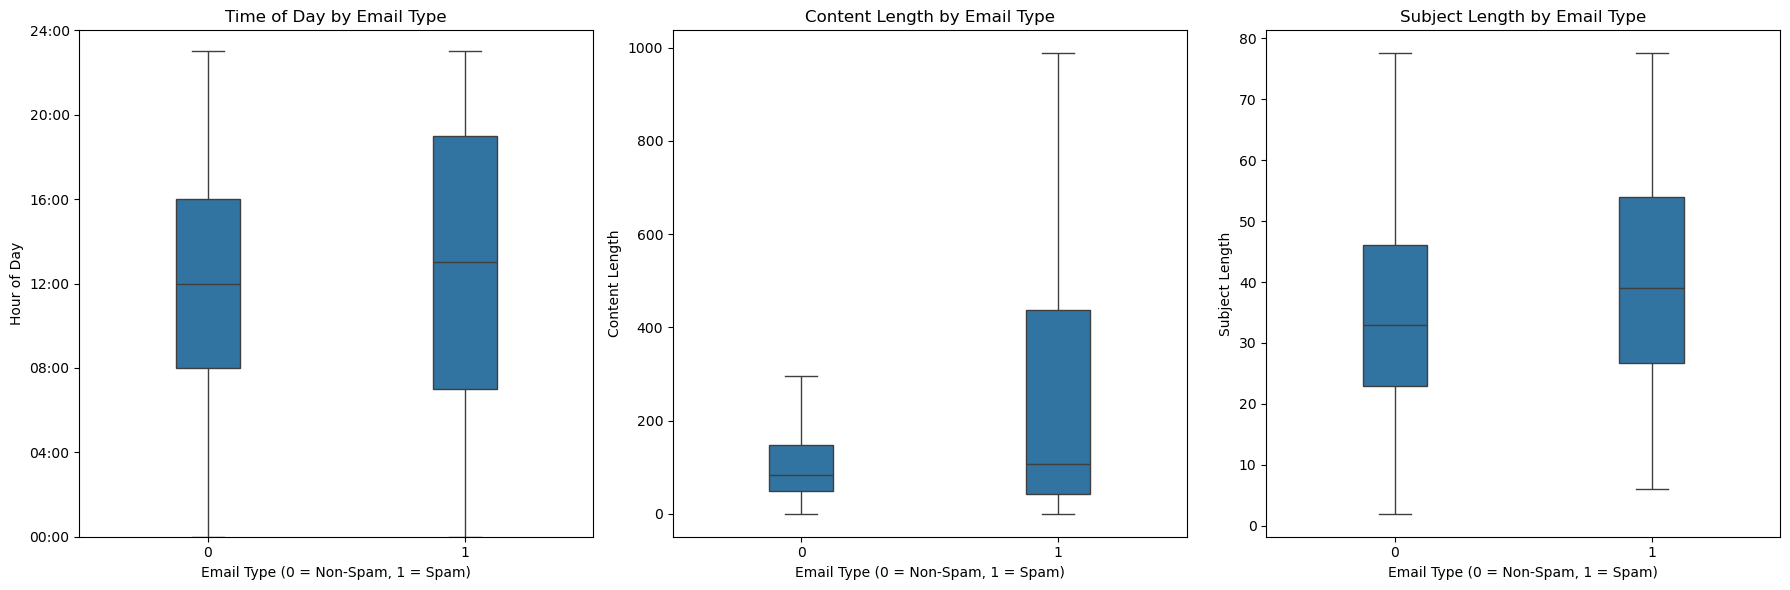

In [18]:
# First, ensure time_of_day is properly stored as float
if df['time_of_day'].dtype != 'float64':
    df['time_of_day'] = df['time_of_day'].astype(float)

fig, axes = plt.subplots(1, 3, figsize=(18, 6))

# Fix time of day plot
sns.boxplot(x='is_spam', y='time_of_day', data=df, ax=axes[0], showfliers=False, width=0.25)
axes[0].set_title('Time of Day by Email Type')
axes[0].set_xlabel('Email Type (0 = Non-Spam, 1 = Spam)')
axes[0].set_ylabel('Hour of Day')
axes[0].set_ylim(0, 24)  # Set limits to 0-24 hours
axes[0].set_yticks(range(0, 25, 4))  # Show ticks at 0, 4, 8, 12, 16, 20, 24
axes[0].set_yticklabels([f"{h:02d}:00" for h in range(0, 25, 4)])  # Format as HH:00

# Content length plot
sns.boxplot(x='is_spam', y='content_length', data=df, ax=axes[1], showfliers=False, width=0.25) 
axes[1].set_title('Content Length by Email Type')
axes[1].set_xlabel('Email Type (0 = Non-Spam, 1 = Spam)')
axes[1].set_ylabel('Content Length')

# Subject length plot
sns.boxplot(x='is_spam', y='subject_length', data=df, ax=axes[2], width=0.25)    
axes[2].set_title('Subject Length by Email Type')
axes[2].set_xlabel('Email Type (0 = Non-Spam, 1 = Spam)')
axes[2].set_ylabel('Subject Length')

plt.tight_layout()
plt.show()

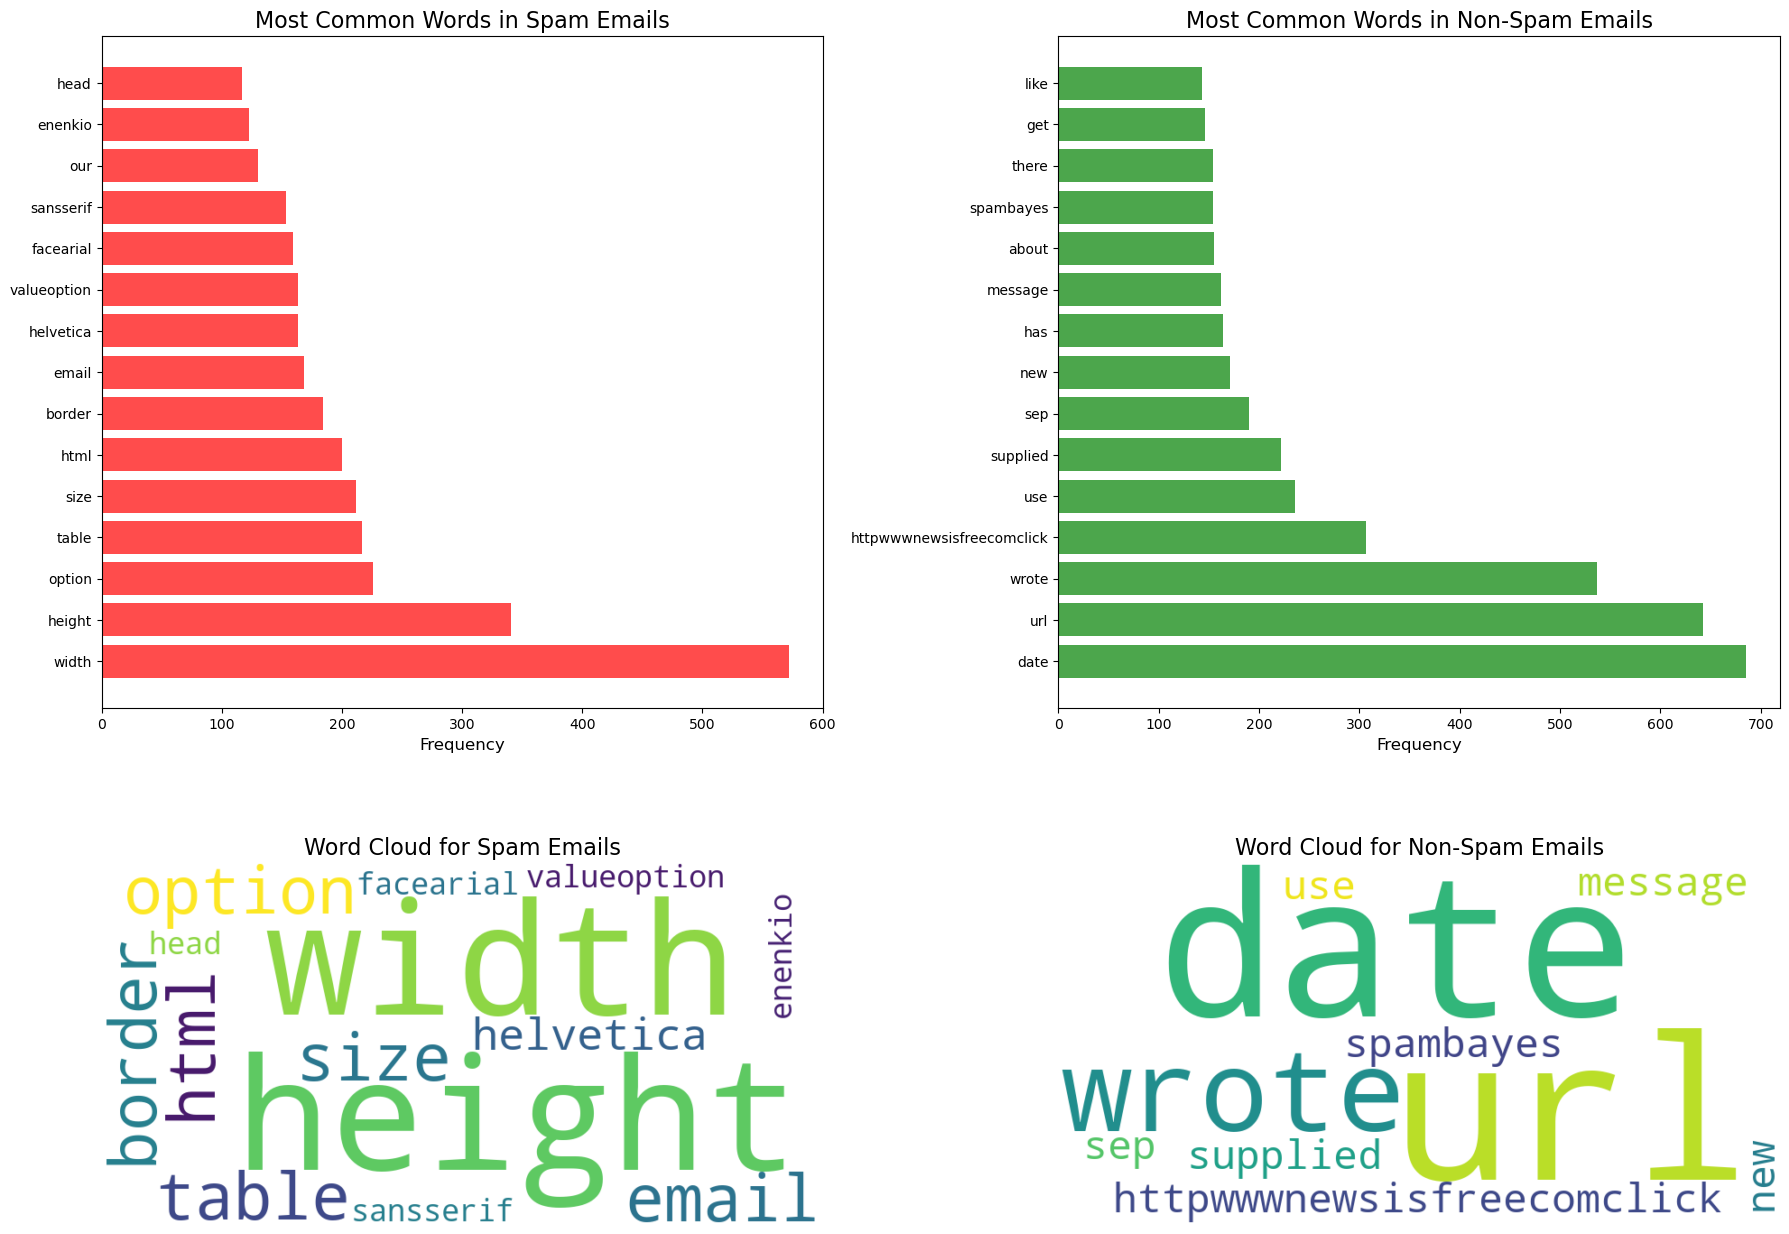

In [19]:
# Function to clean and tokenize text
def clean_text(text):
    if isinstance(text, str):
        # Remove non-alphanumeric characters and convert to lowercase
        text = re.sub(r'[^a-zA-Z\s]', '', text.lower())
        # Split into words and filter out short words (likely not meaningful)
        return [word for word in text.split() if len(word) > 2]
    return []

# Combine content and subject for analysis, converting to string and handling NaN
df['text_for_analysis'] = df['content'].astype(str) + ' ' + df['subject'].astype(str)
# Separate spam and ham content, ensuring all are strings
spam_text = ' '.join(df[df['is_spam'] == 1]['text_for_analysis'].astype(str))
ham_text = ' '.join(df[df['is_spam'] == 0]['text_for_analysis'].astype(str))

# Clean and tokenize
spam_words = clean_text(spam_text)
ham_words = clean_text(ham_text)

# Get word frequency counts
spam_word_counts = Counter(spam_words)
ham_word_counts = Counter(ham_words)

# Remove common English stopwords not caught by the basic cleaning
stop_words = ['the', 'and', 'this', 'that', 'with', 'from', 'your', 'have', 'for',
              'not', 'are', 'you', 'any', 'was', 'but', 'what', 'all', 'when',
              'can', 'will', 'just', 'been', 'other', 'they', 'their', 'some']

for word in stop_words:
    spam_word_counts.pop(word, None)
    ham_word_counts.pop(word, None)

# Get most common words
most_common_spam = spam_word_counts.most_common(15)
most_common_ham = ham_word_counts.most_common(15)

# Create figure with 2 rows and 2 columns
fig, axes = plt.subplots(2, 2, figsize=(18, 14))

# Plot spam word frequency
spam_words, spam_counts = zip(*most_common_spam)
axes[0, 0].barh(spam_words, spam_counts, color='red', alpha=0.7)
axes[0, 0].set_title('Most Common Words in Spam Emails', fontsize=16)
axes[0, 0].set_xlabel('Frequency', fontsize=12)

# Plot ham word frequency
ham_words, ham_counts = zip(*most_common_ham)
axes[0, 1].barh(ham_words, ham_counts, color='green', alpha=0.7)
axes[0, 1].set_title('Most Common Words in Non-Spam Emails', fontsize=16)
axes[0, 1].set_xlabel('Frequency', fontsize=12)

# Generate word clouds
spam_cloud = WordCloud(width=800, height=400,
                       background_color='white',
                       max_words=100).generate(' '.join(spam_words))

ham_cloud = WordCloud(width=800, height=400,
                      background_color='white',
                      max_words=100).generate(' '.join(ham_words))

# Display word clouds
axes[1, 0].imshow(spam_cloud, interpolation='bilinear')
axes[1, 0].axis('off')
axes[1, 0].set_title('Word Cloud for Spam Emails', fontsize=16)

axes[1, 1].imshow(ham_cloud, interpolation='bilinear')
axes[1, 1].axis('off')
axes[1, 1].set_title('Word Cloud for Non-Spam Emails', fontsize=16)

plt.tight_layout()
plt.show()

# Building the Classifier Pipeline

In [21]:
# Create combined_text column
df['combined_text'] = df[['content', 'sender', 'subject', 'content-type']].astype(str).apply(' '.join, axis=1)

# Features and split
X = df[['combined_text', 'time_of_day', 'content_length', 'subject_length']]
y = df['is_spam']
split_point = int(len(df) * 0.8)
X_train = X.iloc[:split_point]
X_test = X.iloc[split_point:]
y_train = y.iloc[:split_point]
y_test = y.iloc[split_point:]

# Custom tokenizer
def clean_text(text):
    text = text.lower()
    text = re.sub(r'http[s]?://\S+', 'URL', text)
    text = re.sub(r'\d+', 'NUMBER', text)
    text = re.sub(r'[^a-z\s]', '', text)
    return text.split()

# Pipeline
custom_stop_words = ['the', 'and', 'this', 'that', 'with', 'from', 'your', 'have', 'for']
preprocessor = ColumnTransformer(
    transformers=[
        ('text', TfidfVectorizer(tokenizer=clean_text,
                                 stop_words=custom_stop_words + ['english'],
                                 ngram_range=(1, 2),
                                 max_df=0.85,
                                 min_df=3,
                                 token_pattern=None),  # Silences the warning
         'combined_text'),
        ('num', MinMaxScaler(), ['time_of_day', 'content_length', 'subject_length'])
    ]
)
pipeline = Pipeline([
    ('preprocess', preprocessor),
    ('classifier', LogisticRegression(class_weight='balanced', max_iter=1000))
])

# Fit the model
pipeline.fit(X_train, y_train)
y_pred = pipeline.predict(X_test)
y_scores = pipeline.predict_proba(X_test)[:, 1]  # Probabilities for spam

# Classification report
print("Classification Report:")
print(classification_report(y_test, y_pred, target_names=['Ham', 'Spam']))

# Plot 1: Confusion Matrix
plt.figure(figsize=(8, 6))
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Ham', 'Spam'], yticklabels=['Ham', 'Spam'])
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

# Plot 2: Precision-Recall Curve
plt.figure(figsize=(8, 6))
precision, recall, thresholds = precision_recall_curve(y_test, y_scores)
plt.plot(recall, precision, label=f'Precision-Recall Curve')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend()
plt.grid(True)
plt.show()

# Plot 3: ROC Curve
plt.figure(figsize=(8, 6))
fpr, tpr, _ = roc_curve(y_test, y_scores)
roc_auc = auc(fpr, tpr)
plt.plot(fpr, tpr, label=f'ROC Curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], 'k--')  # Random guessing line
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.grid(True)
plt.show()

ValueError: Input X contains NaN.
LogisticRegression does not accept missing values encoded as NaN natively. For supervised learning, you might want to consider sklearn.ensemble.HistGradientBoostingClassifier and Regressor which accept missing values encoded as NaNs natively. Alternatively, it is possible to preprocess the data, for instance by using an imputer transformer in a pipeline or drop samples with missing values. See https://scikit-learn.org/stable/modules/impute.html You can find a list of all estimators that handle NaN values at the following page: https://scikit-learn.org/stable/modules/impute.html#estimators-that-handle-nan-values